# Predicción de daños en el pavimento en formato CRDDC 2022

En este notebook se hacen las predicciones para la CRDDC 2022.

In [11]:
# Import libraries
import time
import os
from tqdm import tqdm
from ultralytics import YOLO
import pandas as pd

In [12]:
# Constantes
REGION = 'United_States'
PATH = os.path.join('../data/rdd2022-DatasetNinja', REGION, 'test/images')
PATH_MODEL = '../runs/detect/gcolab_small_United_States_cv0_60ex50b_pt/weights/best.pt'
MODEL_NAME = PATH_MODEL.split('/')[-3]
PRED_PATH = f'../predictions/{MODEL_NAME}/{REGION}'

In [13]:
'''
For each image in the test dataset, your algorithm needs to predict a list of labels, and the corresponding bounding boxes. The output is expected to contain the following two columns:

ImageId: the id of the test image, for example, India_00001
PredictionString: the prediction string should be space-delimited of 5 integers. For example, 2 240 170 260 240 means it's label 2, with a bounding box of coordinates (x_min, y_min, x_max, y_max). We accept up to 5 predictions. For example, if you submit 3 42 24 170 186 1 292 28 430 198 4 168 24 292 190 5 299 238 443 374 2 160 195 294 357 6 1 224 135 356 which contains 6 bounding boxes, we will only take the first 5 into consideration.
'''

# Lista de imagenes de test
images = os.listdir(PATH)

# Inicializar modelo
model = YOLO(PATH_MODEL)

# Inicializar lista de predicciones
predictions = []

# Realizar predicciones
for image in tqdm(images):
    # Realizar predicciones
    results = model(PATH + '/' + image, verbose=False)
    # Obtener predicciones
    classes, boxes = results[0].boxes.cls, results[0].boxes.xyxy
    # Formatear predicciones
    pred_str = ' '.join(f'{int(c)+1} {int(b[0])} {int(b[1])} {int(b[2])} {int(b[3])}' for c, b in zip(classes, boxes))
    # Agregar predicciones a la lista
    predictions.append([image, pred_str])

100%|██████████| 1200/1200 [02:34<00:00,  7.77it/s]


In [14]:
# Pasamos a formato csv sin header
df = pd.DataFrame(predictions, columns=['ImageId', 'PredictionString'])
# Remove any duplicate ImageId
df = df.drop_duplicates(subset='ImageId')
# Sort by ImageId
df = df.sort_values(by='ImageId')
# Comprobamos si la carpeta de predicciones existe
if not os.path.exists(f'../predictions/{MODEL_NAME}'):
    os.makedirs(f'../predictions/{MODEL_NAME}')
# Guardamos las predicciones
df.to_csv(f'{PRED_PATH}.csv', index=False, header=False)

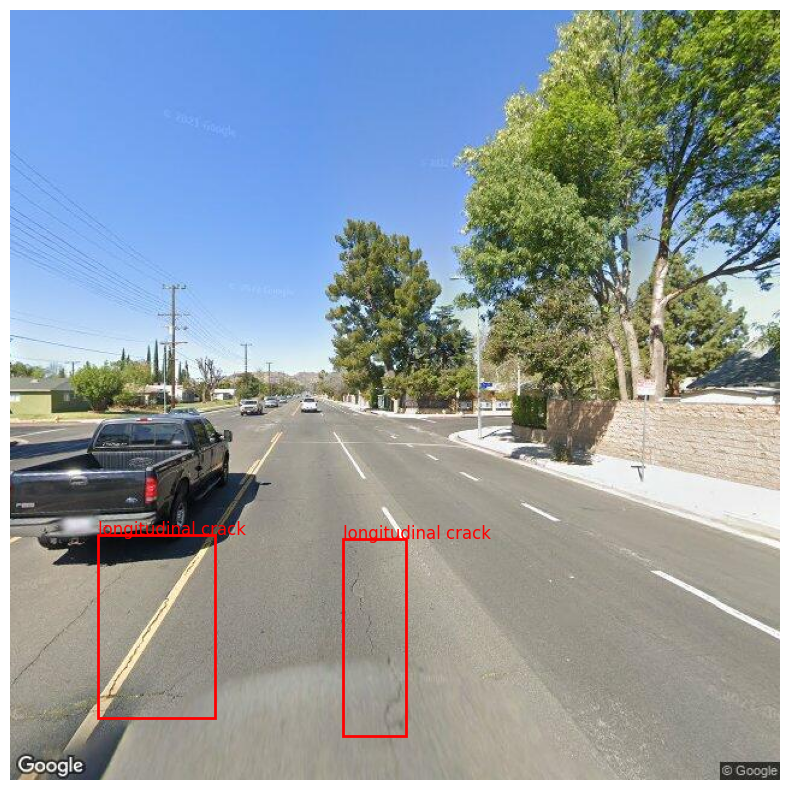

In [15]:
# Open the first image and show the corresponding predictions
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

class_translations = {
    1: 'longitudinal crack',
    2: 'transverse crack',
    3: 'alligator crack',
    4: 'pot hole',
}

image_num = 500

# Load the image
image = cv2.imread(PATH + '/' + df['ImageId'].iloc[image_num])
# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Get the corresponding predictions
predictions = df['PredictionString'].iloc[image_num].split(' ')
# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
# Plot the bounding boxes
for i in range(0, len(predictions), 5):
    class_id = int(predictions[i])
    x_min, y_min, x_max, y_max = int(predictions[i+1]), int(predictions[i+2]), int(predictions[i+3]), int(predictions[i+4])
    ax = plt.gca()
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x_min, y_min, class_translations[class_id], fontsize=12, color='r')
plt.axis('off')
plt.show()